<a href="https://colab.research.google.com/github/Rawan-AbdElmoneim/Husky-vs-Wolf-Image-Classification/blob/main/HuskyVsWolf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required imports

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [ ]:
dataset_path = r"C:\Users\Rawan\Desktop\term 9\Pattern Recognition\train"

def load_data(dataset_path, image_size=(128, 128)):
    images = []
    labels = []
    classes = ['husky_withoutbg', 'wolf_withoutbg']
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            image = image.resize(image_size)
            images.append(np.array(image) / 255.0) # normalization
            labels.append(classes.index(class_name))
    return np.array(images), np.array(labels)


# Visualize sample image-label pairs for Husky and Wolf


Sample Husky images:


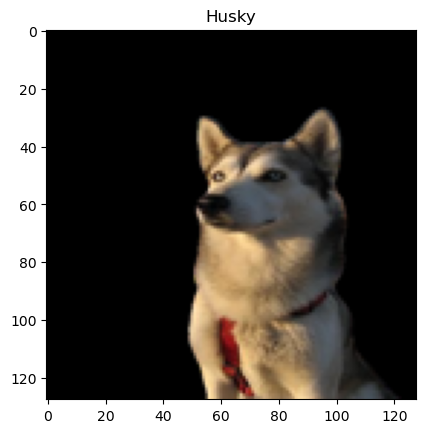

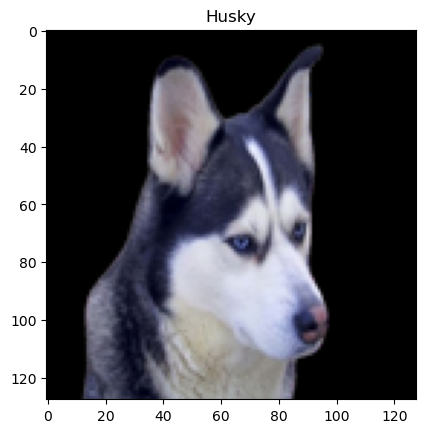

Sample Wolf images:


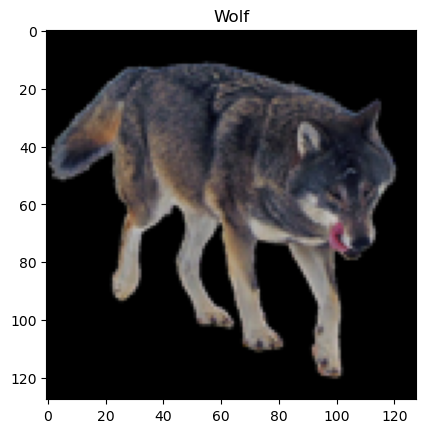

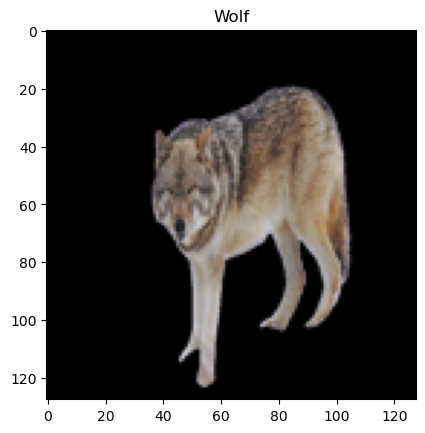

In [ ]:
# Load the dataset
images, labels = load_data(dataset_path)

print("Sample Husky images:")
husky_images = images[labels == 0]
for i in range(2):
    plt.imshow(husky_images[i])
    plt.title("Husky")
    plt.show()

print("Sample Wolf images:")
wolf_images = images[labels == 1]
for i in range(2):
    plt.imshow(wolf_images[i])
    plt.title("Wolf")
    plt.show()

# Function to define the CNN model

# hyperparameter tunning :

## L2 regularization:
### Used in the convolution and dense layers, as it helps in reducing overfitting




## Dropout:
### The dropout rate (0.5) is set, which is another form of regularization.

In [ ]:
def create_model():
    model = Sequential()
    # relu solves the vanishing gradient problem
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                     input_shape=(128, 128, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    #to normalize the interlayer outputs of a neural network
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # to make the multidimensional input one dimensional ,
    # commonly used in the transition from the conv layer to the fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.5))  # Dropout layer randomly sets input units to 0 to reduce overfitting
    # sigmoid used in binary classification
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    # Compile the model with a low learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# Function to preprocess images


In [ ]:
def preprocess_images(test_path, image_size=(128, 128)):
    images = []
    labels = []
    classes = ['husky_withoutbg', 'wolf_withoutbg']
    for class_name in classes:
        class_dir = os.path.join(test_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            image = image.resize(image_size)
            images.append(np.array(image) / 255.0)
            labels.append(classes.index(class_name))
    return np.array(images), np.array(labels)


# Function to make predictions on test data

# hyperparameter tunning:

## 1- Learning Rate Scheduler:
### adjusts the learning rate based on validation loss, which is a form of tuning the learning rate during training.

## 2-Data Augmentation:
### rotation, width shift, height shift, etc. are also hyperparameters that can affect model performance.

In [ ]:
def make_prediction(X_test, model):
    predictions = model.predict(X_test)
    binary_predictions = (predictions > 0.5).astype("int32")
    return binary_predictions

## K-Fold is a robust technique used to evaluate the performance of the model.
## It helps ensure that the model generalizes well to unseen data by using different portions of the dataset for training and testing in multiple iterations.

In [ ]:
# Load your training data
images, labels = load_data(dataset_path)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
all_fold_accuracies = []

for train_index, val_index in kf.split(images):
    print(f"Training on fold {fold_no}")

    # Split the data into training and validation sets for this fold
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Fit the data generator to the training data
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    # Create the model
    model = create_model()

    # Learning rate scheduler
    # ReduceLROnPlateau reduces learning rate when a metric has stopped improving .for a "patience" number of epochs.
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train the model
    model.fit(datagen.flow(X_train, y_train, batch_size=32),
              validation_data=(X_val, y_val),
              epochs=10,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3), lr_scheduler])

    # Evaluate the model on the validation set
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    val_accuracy = accuracy_score(y_val, y_pred)
    all_fold_accuracies.append(val_accuracy)
    print(f"Fold {fold_no} accuracy: {val_accuracy * 100:.2f}%")

    fold_no += 1

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(all_fold_accuracies)
print(f"Average accuracy across all folds: {avg_accuracy * 100:.2f}%")


Training on fold 1
Epoch 1/10
3/3 [==============================] - 3s 633ms/step - loss: 4.2725 - accuracy: 0.5125 - val_loss: 3.7083 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/10
3/3 [==============================] - 1s 384ms/step - loss: 4.8327 - accuracy: 0.5125 - val_loss: 3.7073 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 3/10
3/3 [==============================] - 1s 432ms/step - loss: 4.3686 - accuracy: 0.6125 - val_loss: 3.6953 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/10
3/3 [==============================] - 1s 550ms/step - loss: 4.5058 - accuracy: 0.6000 - val_loss: 3.6849 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 5/10
3/3 [==============================] - 1s 557ms/step - loss: 4.2608 - accuracy: 0.7000 - val_loss: 3.6754 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 6/10
3/3 [==============================] - 1s 551ms/step - loss: 4.2546 - accuracy: 0.6125 - val_loss: 3.6759 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 7/10
3/3 [=======================

# Placeholder for testing


In [ ]:
test_path = r"C:\Users\Rawan\Desktop\term 9\Pattern Recognition\train"
X_test, y_test = preprocess_images(test_path)
y_pred = make_prediction(X_test, model)
print(f"Test accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


4/4 [==============================] - 0s 63ms/step
Test accuracy: 57.00%


## plot 10 images in a 2x5 grid with their actual and predicted labels

4/4 [==============================] - 0s 63ms/step


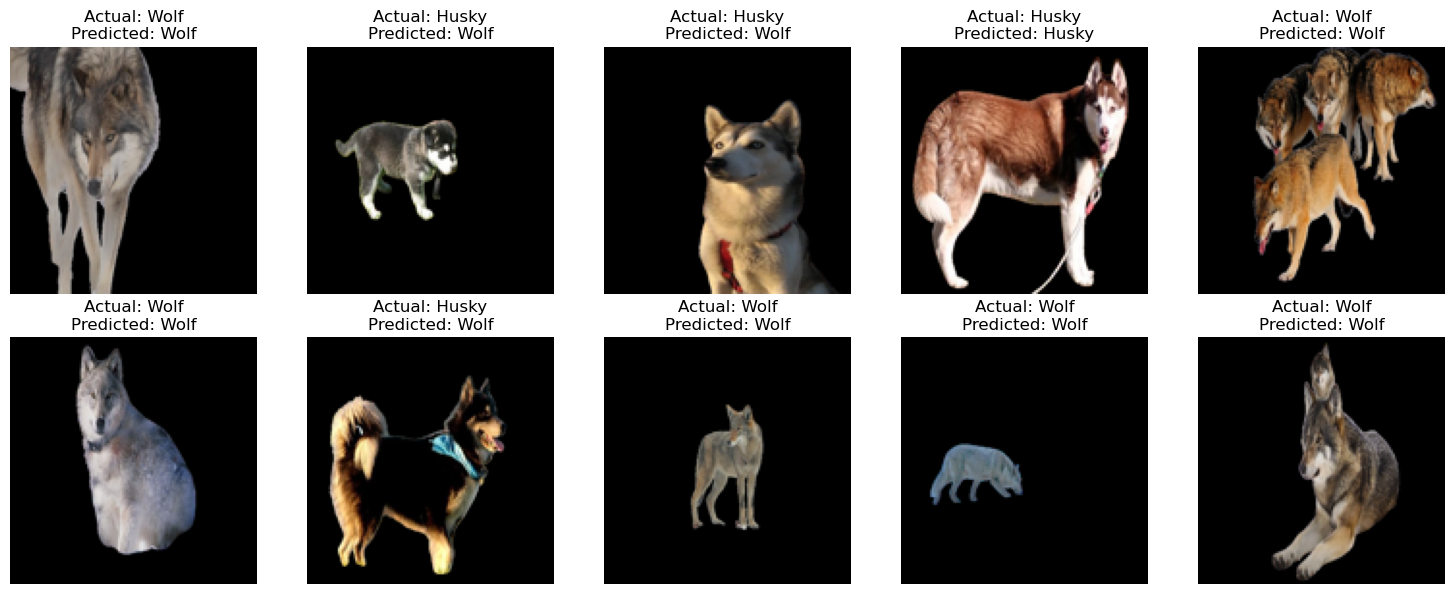

In [ ]:
def plot_predictions(X_test, y_test, model):
    y_pred = make_prediction(X_test, model)

    indices = np.random.choice(len(X_test), 10, replace=False)
    images = X_test[indices]
    actual_labels = y_test[indices]
    predicted_labels = y_pred[indices]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis('off')
        actual = "Husky" if actual_labels[i] == 0 else "Wolf"
        predicted = "Husky" if predicted_labels[i] == 0 else "Wolf"
        ax.set_title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()

# Example usage: plot predictions on the test set
plot_predictions(X_test, y_test, model)
